In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import re
import os 
import keras
import numpy as np

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.layers import LSTM
from keras.layers import BatchNormalization
from keras.models import Model

In [ ]:
MAX_SEQUENCE_LENGTH = 300
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [ ]:
data_train = pd.read_csv("/content/drive/Shareddrives/PRML_Fake News/FA-KES-Dataset.csv", encoding ='ISO-8859-1')
data_train.head()

,unit_id,article_title,article_content,source,date,location,labels
0,1914947530,Syria attack symptoms consistent with nerve ag...,Wed 05 Apr 2017 Syria attack symptoms consiste...,nna,4/5/2017,idlib,0
1,1914947532,Homs governor says U.S. attack caused deaths b...,Fri 07 Apr 2017 at 0914 Homs governor says U.S...,nna,4/7/2017,homs,0
2,1914947533,Death toll from Aleppo bomb attack at least 112,Sun 16 Apr 2017 Death toll from Aleppo bomb at...,nna,4/16/2017,aleppo,0
3,1914947534,Aleppo bomb blast kills six Syrian state TV,Wed 19 Apr 2017 Aleppo bomb blast kills six Sy...,nna,4/19/2017,aleppo,0
4,1914947535,29 Syria Rebels Dead in Fighting for Key Alepp...,Sun 10 Jul 2016 29 Syria Rebels Dead in Fighti...,nna,7/10/2016,aleppo,0


In [ ]:
texts = []
labels = []

for i in range(data_train.article_content.shape[0]):
    text1 = data_train.article_title[i]
    text2 = data_train.article_content[i]
    text = str(text1) +""+ str(text2)
    texts.append(text)
    labels.append(data_train.labels[i])
    
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 10776 unique tokens.


In [ ]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = keras.utils.to_categorical(np.asarray(labels),num_classes = 2)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (804, 300)
Shape of label tensor: (804, 2)


In [ ]:
# Train test validation Split
from sklearn.model_selection import train_test_split

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_train, x_test, y_train, y_test = train_test_split( data, labels, test_size=0.20, random_state=42)
x_test, x_val, y_test, y_val = train_test_split( x_test, y_test, test_size=0.50, random_state=42)
print('Size of train, test:', len(y_train), len(y_val), len(y_test))

print('real & fake news in train, test:')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))
print(y_test.sum(axis=0))

Size of train, test: 643 81 80
real & fake news in train, test:
[303. 340.]
[33. 48.]
[42. 38.]


In [ ]:
from keras.models import Sequential
from matplotlib import pyplot as plt

%matplotlib inline

In [ ]:
#Using Pre-trained word embeddings
GLOVE_DIR = "/content/drive/Shareddrives/PRML_Fake News/glove" 
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    #print(values[1:])
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove.' % len(embeddings_index))

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH)

Total 400000 word vectors in Glove.


In [ ]:
EPOCHS = 25

modell = Sequential()
modell.add(embedding_layer)
modell.add(Dropout(0.2))
modell.add(Conv1D(filters=128, kernel_size=5, padding='valid', activation='relu'))
modell.add(MaxPooling1D(pool_size=2))
modell.add(LSTM(100, dropout=0.2))
modell.add(BatchNormalization())

# modell.add(Dense(256, activation='relu'))
# modell.add(Dense(64, activation='relu'))
modell.add(Dense(32, activation='relu'))
modell.add(Dense(2, activation='softmax'))
modell.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(modell.summary())
history=modell.fit(x_train, y_train, epochs=EPOCHS, batch_size=64, validation_data=(x_val,y_val))

modell.save('lstm.h5')

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 300, 100)          1077700   
_________________________________________________________________
dropout_8 (Dropout)          (None, 300, 100)          0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 296, 128)          64128     
_________________________________________________________________
max_pooling1d_44 (MaxPooling (None, 148, 128)          0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 100)               91600     
_________________________________________________________________
batch_normalization_33 (Batc (None, 100)               400       
_________________________________________________________________
dense_82 (Dense)             (None, 32)              

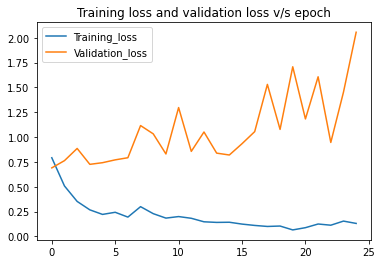

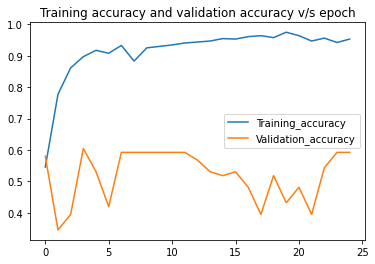

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(range(EPOCHS),history.history['loss'])
plt.plot(range(EPOCHS),history.history['val_loss'])
plt.title("Training loss and validation loss v/s epoch")
plt.legend(["Training_loss","Validation_loss"])
plt.savefig("Kaggle Training loss and validation loss.png")

plt.figure()
plt.plot(range(EPOCHS),history.history['accuracy'])
plt.plot(range(EPOCHS),history.history['val_accuracy'])
plt.title("Training accuracy and validation accuracy v/s epoch")
plt.legend(["Training_accuracy","Validation_accuracy"])
plt.savefig("Kaggle Training accuracy and validation accuracy.png")

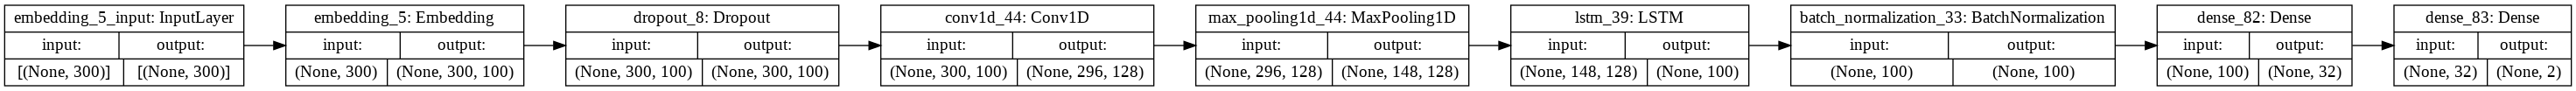

In [ ]:
keras.utils.plot_model(modell, show_shapes=True, rankdir='LR', to_file="kaggle_cnn_rnn_model_plot.png")